In [12]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt

In [13]:
# getting the data

data = pd.read_csv('cleaned_data.csv' , sep = ' ' , header = None)
data

,0,1,2,3,4
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
995,1,1,1,1,1
996,1,1,1,1,1
997,1,1,1,1,1
998,1,1,1,1,1


In [3]:
data_matrix = []

for row in data.iterrows():
    data_matrix.append(list(row[1].values))

data_matrix = np.array(data_matrix)
data_matrix

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [14]:
with pm.Model() as model:
    
    # prior on alpha
    alpha = pm.Normal('alpha', mu=0, sigma=100 , shape = (1,5))
    alpha = alpha - alpha.mean(0)

    # prior on beta
    beta = pm.HalfFlat('beta')

    # prior on theta
    theta = pm.Normal('theta' , mu = 0 , sigma = 1 , shape = (1000,1))

    
    p = pm.Deterministic('p' , beta * theta - alpha)


    y = pm.Bernoulli('y' , logit_p = p , observed = data_matrix)

    trace = pm.sample(5000, tune=1000, return_inferencedata=True , progressbar=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 56 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",0.75,100.02,-190.64,181.85,0.63,0.88,25477.68,12523.50,1.0
"alpha[0, 1]",0.67,100.97,-191.98,186.22,0.64,0.87,24832.40,12795.01,1.0
"alpha[0, 2]",-0.57,99.83,-187.14,186.15,0.63,0.84,25369.66,13441.23,1.0
"alpha[0, 3]",-0.52,100.52,-190.16,189.66,0.64,0.85,24939.39,12625.42,1.0
"alpha[0, 4]",-0.26,100.89,-195.67,185.53,0.60,0.89,27875.98,12139.93,1.0
beta,1.58,0.07,1.45,1.72,0.00,0.00,4560.52,7687.88,1.0


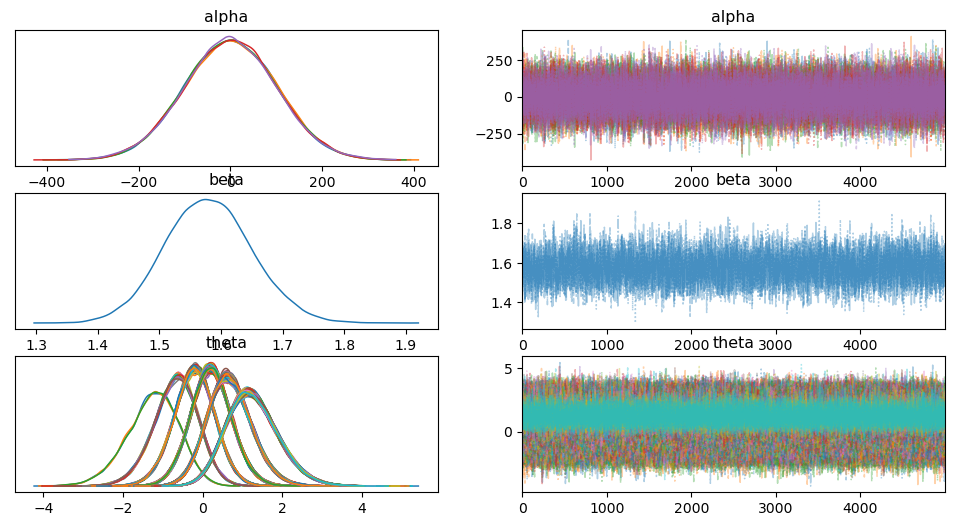

In [15]:
az.plot_trace(trace , var_names = ['alpha' , 'beta' , 'theta'] , combined = True)

with model:
    display(az.summary(trace , var_names = ['alpha' , 'beta'] , round_to = 2))

In [17]:
with model:
    posterior = az.summary(trace , var_names = ['alpha' , 'beta' , 'theta'] , round_to = 2)

In [22]:
dict_means = posterior['mean'].to_dict()

In [34]:
# we shall try to make predictions now and calculate the error using Hamming distance
error = 0

for i in range(1000):
    for j in range(5):
        linear_term = dict_means['beta'] * dict_means["theta["+ str(i)+", 0]"] - dict_means["alpha[0, "+ str(j)+"]"]
        prob = np.exp(linear_term) / (1 + np.exp(linear_term))
        if prob > 0.5:
            term = 1
        else:
            term = 0

        if term != data_matrix[i][j]:
            error += 1

print("Using MCMC, the error is {} , resulting in an accuracy of {}".format(error , 100 - (error/5000*100)))        

The error is 1289 , resulting in an accuracy of 74.22


In [35]:
with pm.Model() as model:
    
    # prior on alpha
    alpha = pm.Normal('alpha', mu=0, sigma=100 , shape = (1,5))
    alpha = alpha - alpha.mean(0)

    # prior on beta
    beta = pm.HalfFlat('beta')

    # prior on theta
    theta = pm.Normal('theta' , mu = 0 , sigma = 1 , shape = (1000,1))

    
    p = pm.Deterministic('p' , beta * theta - alpha)


    y = pm.Bernoulli('y' , logit_p = p , observed = data_matrix)

    mean_field = pm.fit(2500, method='advi')

Finished [100%]: Average Loss = 3,496.9


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/tanmaygoyal/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


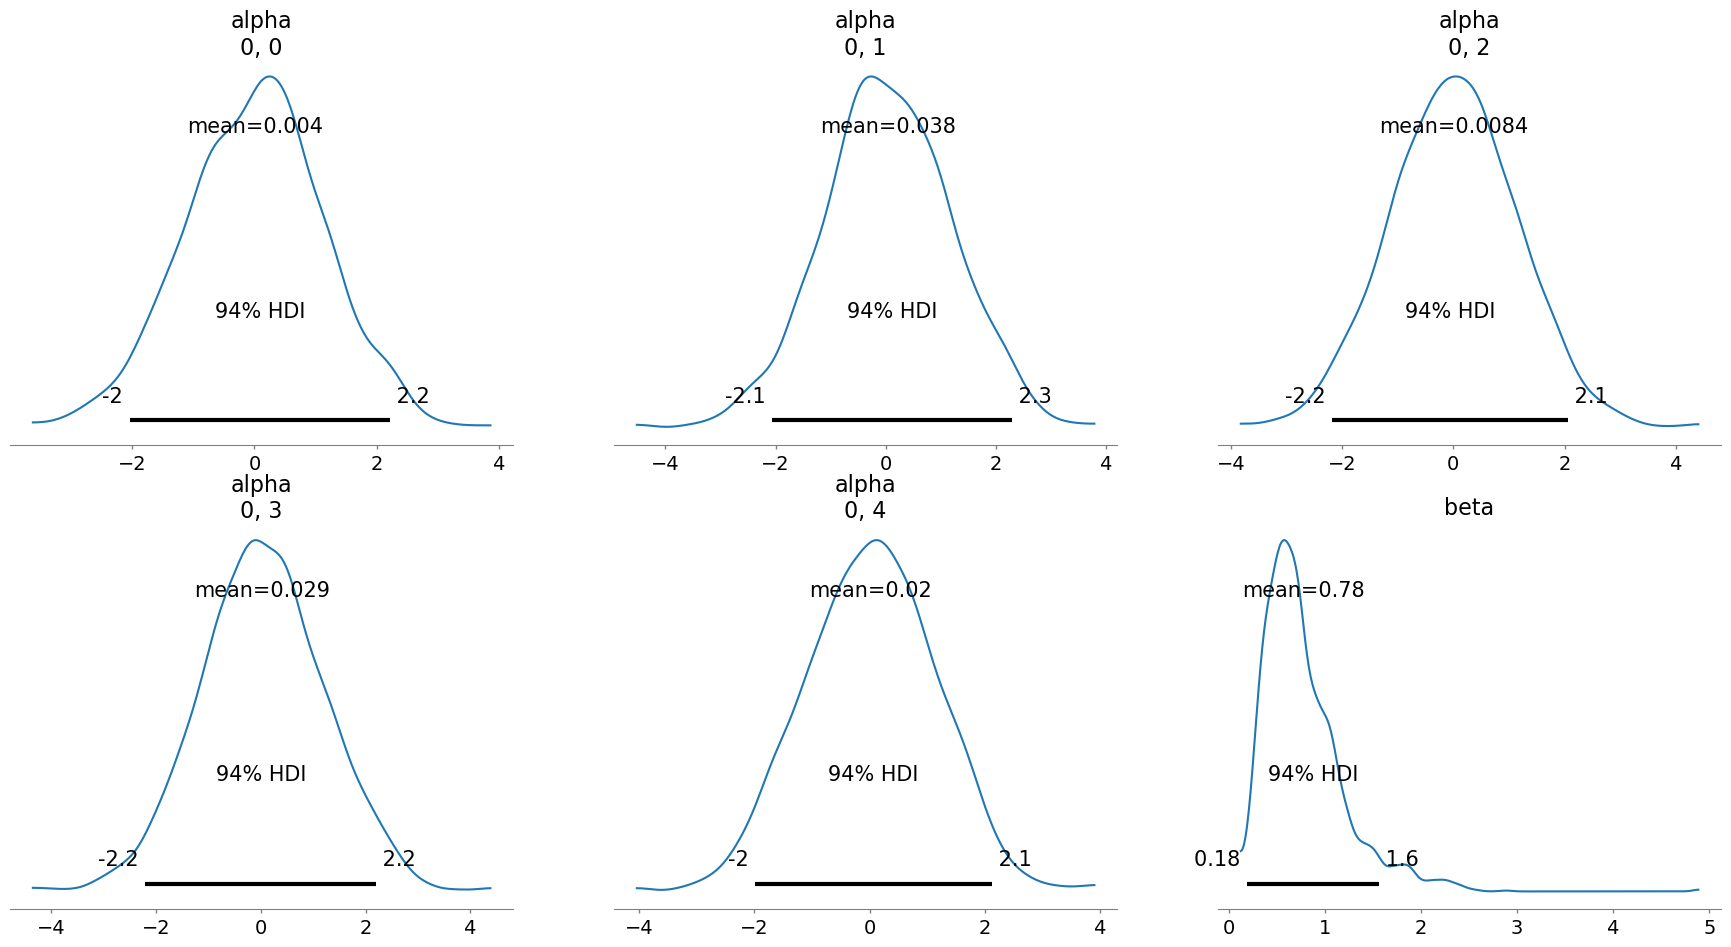

In [36]:
trace = mean_field.sample(2000)
pm.plot_posterior(trace , var_names = ['alpha' , 'beta'])
plt.show()

In [37]:
display(az.summary(trace , var_names = ['alpha' , 'beta'] , round_to = 2))

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",0.00,1.13,-2.04,2.22,0.03,0.02,1823.76,1893.01,NaN
"alpha[0, 1]",0.04,1.16,-2.06,2.30,0.03,0.02,2065.93,1997.48,NaN
"alpha[0, 2]",0.01,1.15,-2.19,2.06,0.03,0.02,2030.94,1819.00,NaN
"alpha[0, 3]",0.03,1.18,-2.20,2.20,0.03,0.02,1940.69,2032.91,NaN
"alpha[0, 4]",0.02,1.13,-1.98,2.12,0.03,0.02,1998.21,1716.74,NaN
beta,0.78,0.42,0.18,1.57,0.01,0.01,1919.45,1847.15,NaN


In [38]:
with model:
    posterior = az.summary(trace , var_names = ['alpha' , 'beta' , 'theta'] , round_to = 2)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


In [39]:
dict_means = posterior['mean'].to_dict()

In [41]:
# we shall try to make predictions now and calculate the error using Hamming distance
error = 0

for i in range(1000):
    for j in range(5):
        linear_term = dict_means['beta'] * dict_means["theta["+ str(i)+", 0]"] - dict_means["alpha[0, "+ str(j)+"]"]
        prob = np.exp(linear_term) / (1 + np.exp(linear_term))
        if prob > 0.5:
            term = 1
        else:
            term = 0

        if term != data_matrix[i][j]:
            error += 1

print("Using Variation Inference, the error is {} , resulting in an accuracy of {}".format(error , 100 - (error/5000*100)))        

Using Variation Inference, the error is 1021 , resulting in an accuracy of 79.58
